In [1]:
from utils.dataloader import *
from utils.sift import *
from utils.helper import strech_img, plot_img_and_hist, combine_labels
from utils.classifier import grid_search, get_report
import pandas as pd
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split
import pickle

In [2]:
OUT_PATH = '/Users/moooooo16/Documents/Computer Vision/Project/elpv/out'

sift_data , sift_features, sift_kmeans, sift_results = None, None, None, None

with open(os.path.join(OUT_PATH, 'sift_data.pkl'), 'rb') as f:
    sift_data = pickle.load(f)

    
with open(os.path.join(OUT_PATH, 'sift_kmeans.pkl'), 'rb') as f:
    kmeans = pickle.load(f)

with open(os.path.join(OUT_PATH, 'sift_results.pkl'), 'rb') as f:
    sift_results = pickle.load(f)

print(kmeans.keys())

dict_keys([64, 128, 256, 384, 512, 640, 768, 896, 1024])


In [3]:
KS = [64, 128, 256, 384, 512, 640, 768, 896, 1024]
RANDOME_STATE= 66

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


knn_params = {
    'n_neighbors': [5,7,9,11,13, 15, 17, 19, 21],
}


svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}


forest_params = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10]
}


logreg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}


tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


adaboost_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}


gradientboost_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}


knn = KNeighborsClassifier(metric='euclidean')
svm = SVC(tol=1e-3)
forest = RandomForestClassifier()
logreg = LogisticRegression()
tree = DecisionTreeClassifier()
adaboost = AdaBoostClassifier()
gradientboost = GradientBoostingClassifier()
gnb = GaussianNB()
lda = LinearDiscriminantAnalysis()

# Combine classifiers and their parameters
params = [knn_params, svm_params, forest_params, logreg_params, tree_params, adaboost_params, gradientboost_params]
clfs = [knn, svm, forest, logreg, tree, adaboost, gradientboost, gnb, lda]
names = ['knn', 'svm', 'forest', 'logreg', 'tree', 'adaboost', 'gradientboost', 'gnb', 'lda']

results = []
reports =  {name: [] for name in names}
# You can now iterate over clfs and params and perform grid search or other evaluation as needed.


In [5]:
sift = SIFT(None,[])
X_train, X_val, X_test, y_train, y_val, y_test = sift_data
X_train = X_train + X_val
y_train = y_train + y_val

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

1968 1968
656 656


In [6]:
# 对于不同的K， 每个clf 都会进行 grid search
# 单词GridSearch会CV5次，测试N个不同的参数
# 单次GridSerach会返回一个plot

for k in KS:
    # Put clusters into bins, count number of descriptors in each bin
    hist_train = sift.get_features(X_train, kmeans[k], k)
    hist_test = sift.get_features(X_test, kmeans[k], k)
    
    # train a classifier use histogram

    for clf, param, name in zip(clfs, params, names):


        result, clf, pred, acc, conf_mat = grid_search(hist_train, y_train,
                                                hist_test, y_test,
                                                clf, param, 
                                                cv = 5, scoring='accuracy', verbose=0,
                                                n_jobs=-1, return_train_score=True)

        results.append({'k': k, 
                        'clf': clf, 
                        'params': clf.get_params(), 
                        'pred': pred,
                        'acc': acc,
                        'conf_mat': conf_mat,})
        reports[name].append(result)
        print("--"*50)
        print()


the_best = max(results, key=lambda x: x['acc'])
print()
print("--"*50)
print("--"*50)
print('Best K:', the_best['k'])
print('Average acc:', the_best['acc'])
print('Parameters:', the_best['params'])
print('Confusion matrix:\n', the_best['conf_mat'])


with open(os.path.join(OUT_PATH, 'sift_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

Building histogram: 100%|██████████| 656/656 [00:00<00:00, 726.71it/s]


Best Score: 0.6742692551116622 use {'n_neighbors': 5}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       147
           1       0.60      0.10      0.18        29
           2       0.00      0.00      0.00        14
           3       0.75      0.55      0.64        78
           4       0.72      0.85      0.78       230
           5       0.42      0.24      0.31        45
           6       0.50      0.08      0.13        13
           7       0.60      0.43      0.50       100

    accuracy                           0.67       656
   macro avg       0.53      0.40      0.41       656
weighted avg       0.64      0.67      0.63       656


----------------------------------------------------------------------------------------------------

Best Score: 0.6742705467508816 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0 

Building histogram: 100%|██████████| 656/656 [00:00<00:00, 725.47it/s]


Best Score: 0.6590240374058718 use {'n_neighbors': 15}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       147
           1       0.50      0.07      0.12        29
           2       0.00      0.00      0.00        14
           3       0.68      0.56      0.62        78
           4       0.71      0.90      0.79       230
           5       0.46      0.13      0.21        45
           6       0.00      0.00      0.00        13
           7       0.66      0.40      0.50       100

    accuracy                           0.68       656
   macro avg       0.46      0.38      0.38       656
weighted avg       0.63      0.68      0.62       656


----------------------------------------------------------------------------------------------------

Best Score: 0.6971299776546415 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0

Building histogram: 100%|██████████| 656/656 [00:00<00:00, 675.01it/s]


Best Score: 0.6381911884372458 use {'n_neighbors': 19}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.77       147
           1       0.50      0.07      0.12        29
           2       0.00      0.00      0.00        14
           3       0.50      0.59      0.54        78
           4       0.73      0.75      0.74       230
           5       0.40      0.04      0.08        45
           6       0.00      0.00      0.00        13
           7       0.53      0.46      0.49       100

    accuracy                           0.63       656
   macro avg       0.41      0.36      0.34       656
weighted avg       0.59      0.63      0.58       656


----------------------------------------------------------------------------------------------------

Best Score: 0.6940946254892084 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0

Building histogram: 100%|██████████| 656/656 [00:01<00:00, 633.47it/s]


Best Score: 0.6066958577130236 use {'n_neighbors': 5}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       147
           1       0.30      0.10      0.15        29
           2       0.14      0.07      0.10        14
           3       0.40      0.51      0.45        78
           4       0.76      0.72      0.74       230
           5       0.39      0.16      0.22        45
           6       0.00      0.00      0.00        13
           7       0.56      0.45      0.50       100

    accuracy                           0.60       656
   macro avg       0.39      0.36      0.36       656
weighted avg       0.58      0.60      0.58       656


----------------------------------------------------------------------------------------------------

Best Score: 0.7123687371643352 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0 

Building histogram: 100%|██████████| 656/656 [00:01<00:00, 593.81it/s]


Best Score: 0.5645251288410121 use {'n_neighbors': 7}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.96      0.71       147
           1       0.44      0.14      0.21        29
           2       0.00      0.00      0.00        14
           3       0.33      0.47      0.39        78
           4       0.73      0.67      0.70       230
           5       0.50      0.13      0.21        45
           6       0.00      0.00      0.00        13
           7       0.54      0.33      0.41       100

    accuracy                           0.57       656
   macro avg       0.39      0.34      0.33       656
weighted avg       0.56      0.57      0.54       656


----------------------------------------------------------------------------------------------------

Best Score: 0.7042443264747291 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0 

Building histogram: 100%|██████████| 656/656 [00:01<00:00, 486.27it/s]


Best Score: 0.533518037741698 use {'n_neighbors': 5}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.93      0.70       147
           1       0.39      0.24      0.30        29
           2       0.00      0.00      0.00        14
           3       0.27      0.50      0.35        78
           4       0.74      0.60      0.66       230
           5       0.36      0.11      0.17        45
           6       0.00      0.00      0.00        13
           7       0.55      0.28      0.37       100

    accuracy                           0.54       656
   macro avg       0.36      0.33      0.32       656
weighted avg       0.54      0.54      0.51       656


----------------------------------------------------------------------------------------------------

Best Score: 0.7022177445395952 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0  

Building histogram: 100%|██████████| 656/656 [00:01<00:00, 542.32it/s]


Best Score: 0.4821921700830524 use {'n_neighbors': 5}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.95      0.67       147
           1       0.58      0.24      0.34        29
           2       0.00      0.00      0.00        14
           3       0.23      0.50      0.32        78
           4       0.77      0.48      0.59       230
           5       0.42      0.11      0.18        45
           6       0.00      0.00      0.00        13
           7       0.52      0.24      0.33       100

    accuracy                           0.49       656
   macro avg       0.38      0.31      0.30       656
weighted avg       0.55      0.49      0.47       656


----------------------------------------------------------------------------------------------------

Best Score: 0.7200061998682529 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0 

Building histogram: 100%|██████████| 656/656 [00:01<00:00, 516.77it/s]


Best Score: 0.4410405445550949 use {'n_neighbors': 5}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.89      0.62       147
           1       0.25      0.17      0.20        29
           2       0.00      0.00      0.00        14
           3       0.16      0.37      0.22        78
           4       0.79      0.38      0.52       230
           5       0.56      0.11      0.19        45
           6       0.00      0.00      0.00        13
           7       0.35      0.16      0.22       100

    accuracy                           0.42       656
   macro avg       0.32      0.26      0.25       656
weighted avg       0.50      0.42      0.40       656


----------------------------------------------------------------------------------------------------

Best Score: 0.7103589465390527 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0 

Building histogram: 100%|██████████| 656/656 [00:01<00:00, 477.83it/s]


Best Score: 0.4135983777011405 use {'n_neighbors': 5}
Testset Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.94      0.64       147
           1       0.31      0.17      0.22        29
           2       0.00      0.00      0.00        14
           3       0.16      0.44      0.23        78
           4       0.74      0.32      0.45       230
           5       0.50      0.07      0.12        45
           6       0.00      0.00      0.00        13
           7       0.39      0.12      0.18       100

    accuracy                           0.40       656
   macro avg       0.32      0.26      0.23       656
weighted avg       0.50      0.40      0.37       656


----------------------------------------------------------------------------------------------------

Best Score: 0.7067862724583769 use {'C': 10, 'kernel': 'rbf'}
Testset Classification Report:
              precision    recall  f1-score   support

           0 

In [7]:
len(reports['knn'])

9

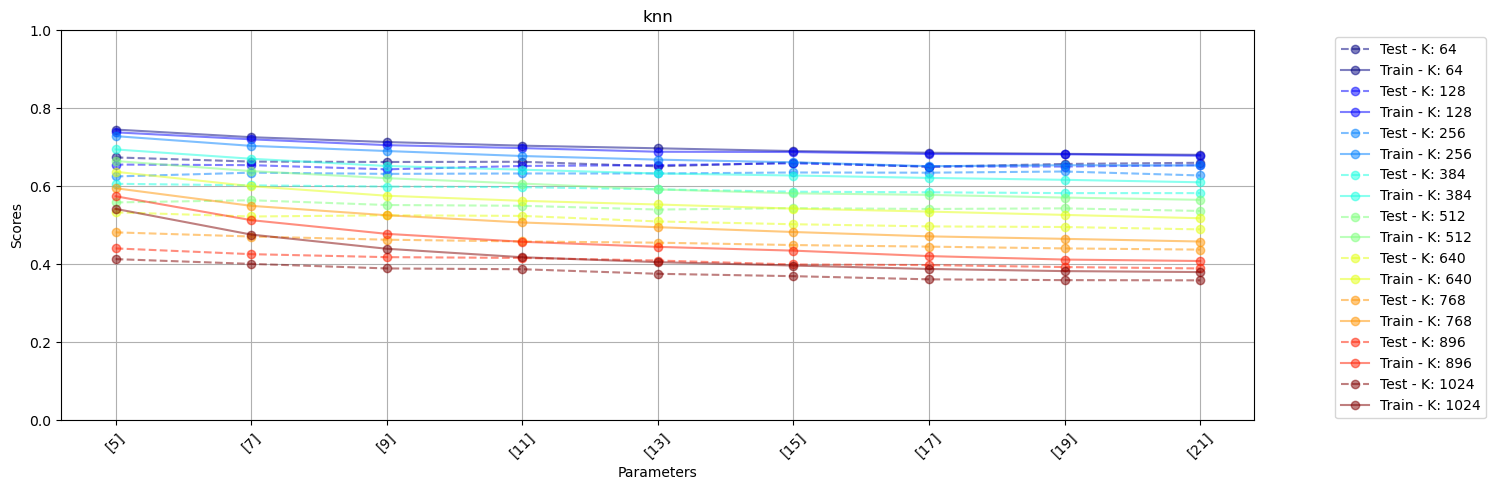

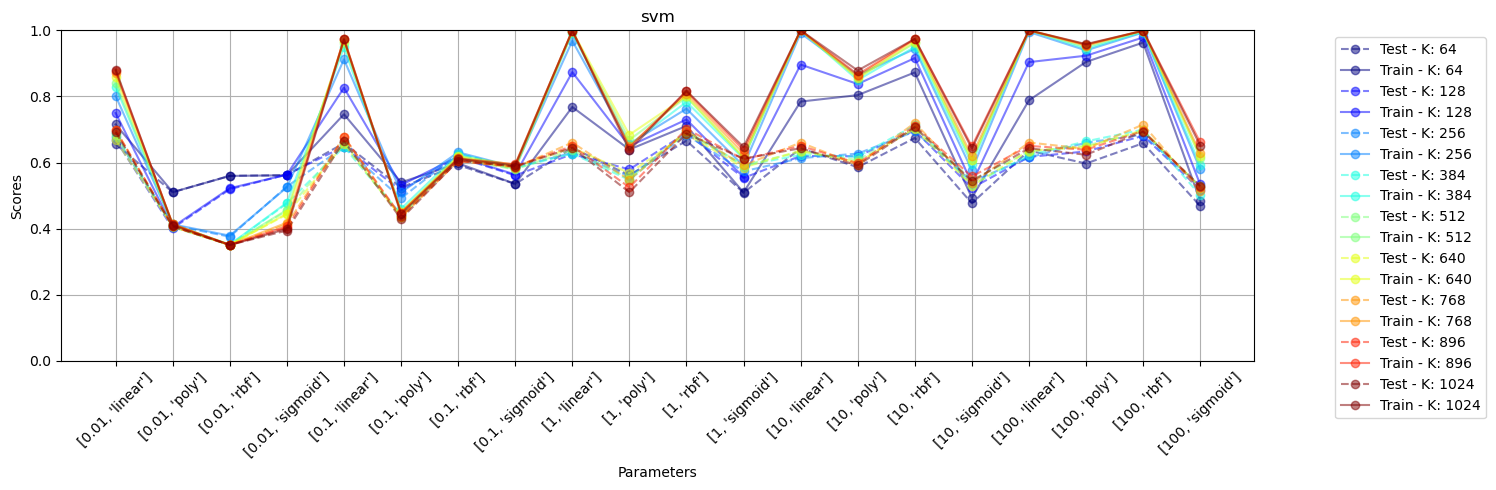

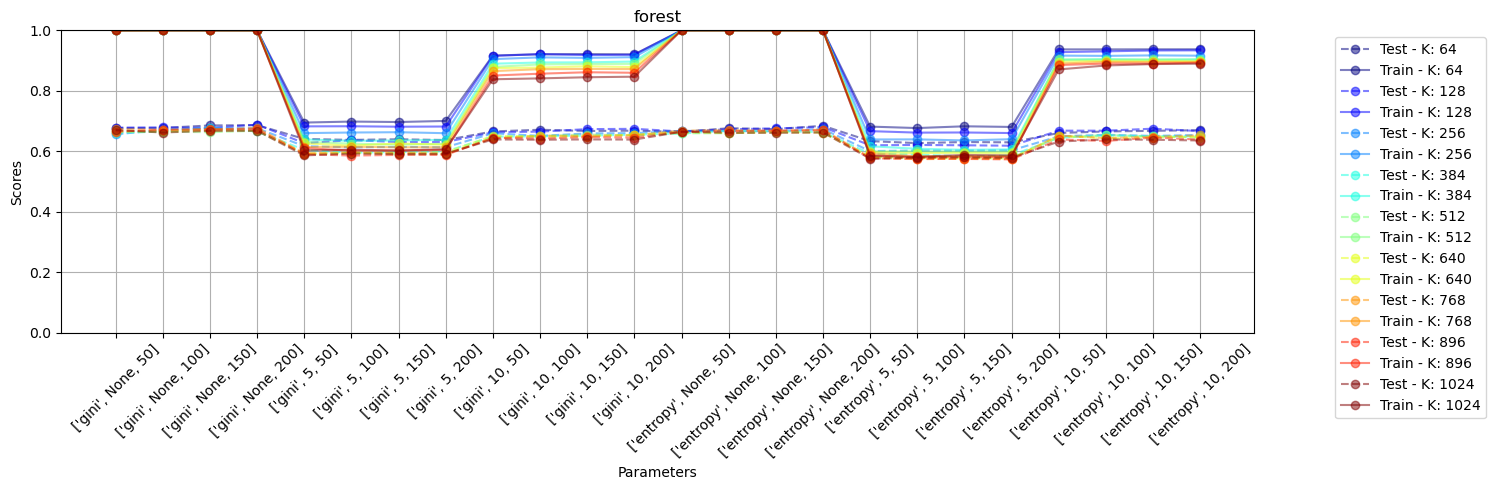

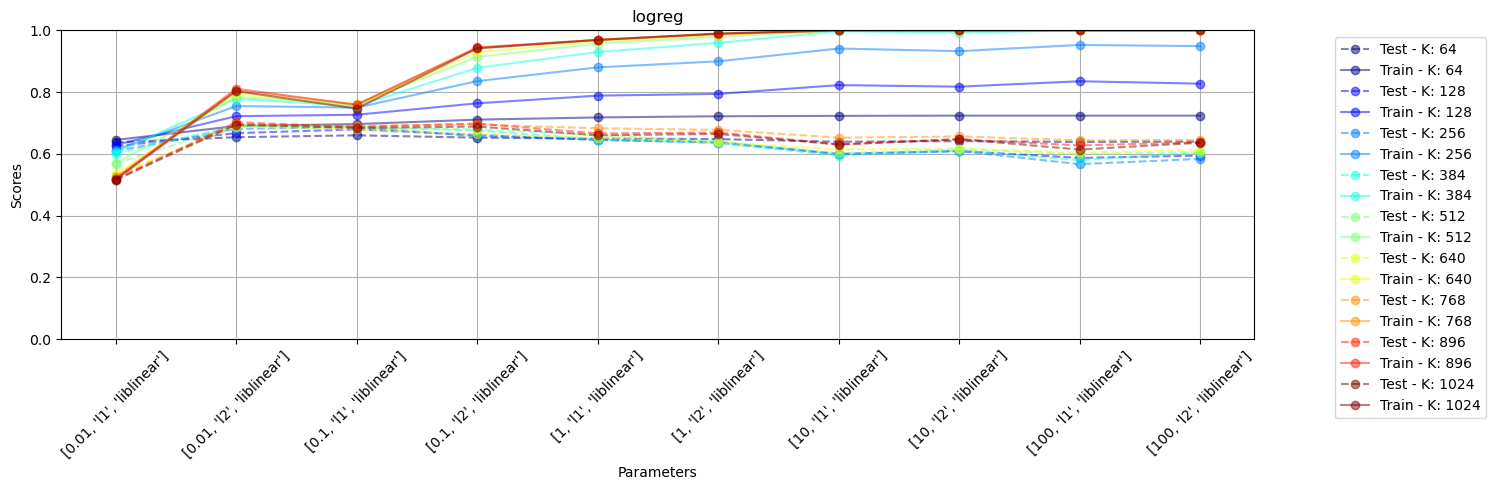

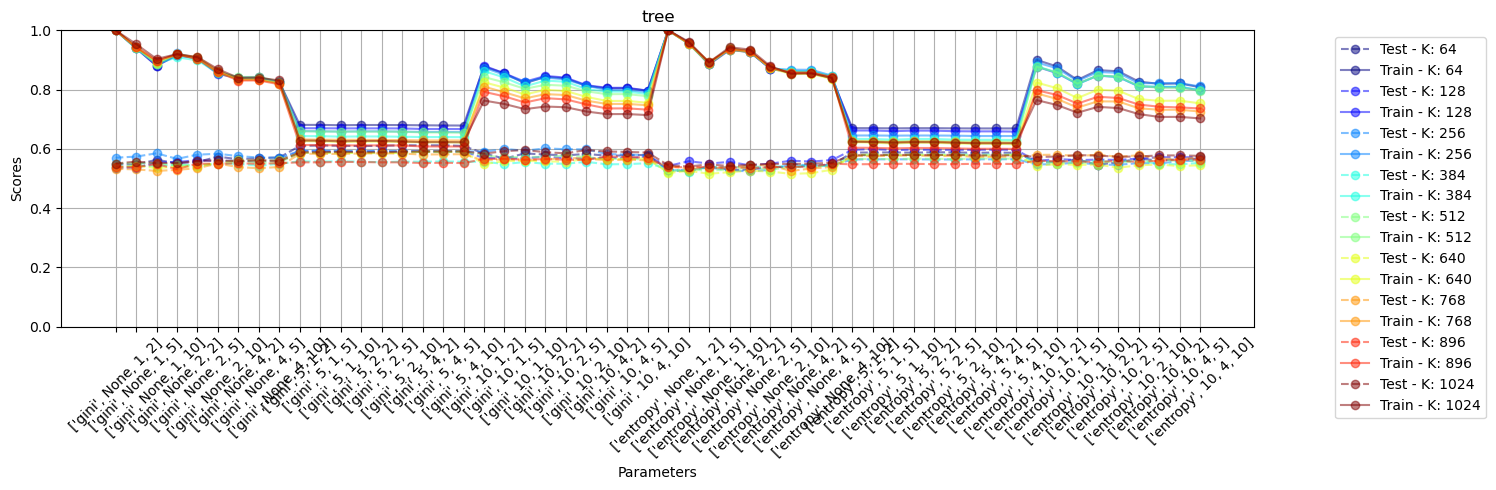

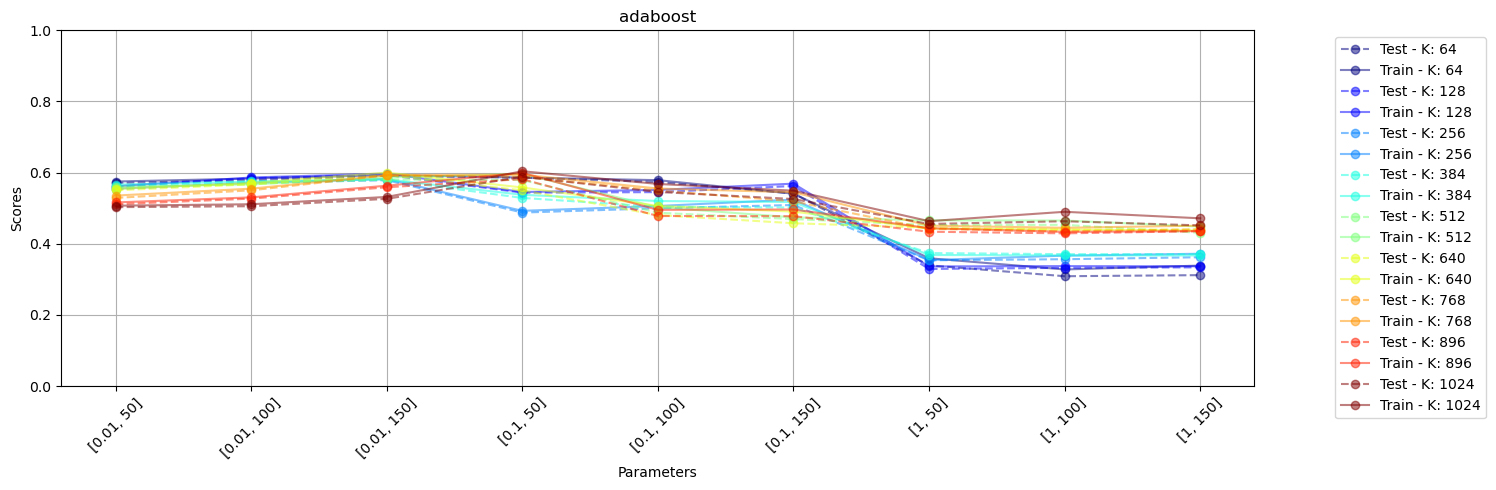

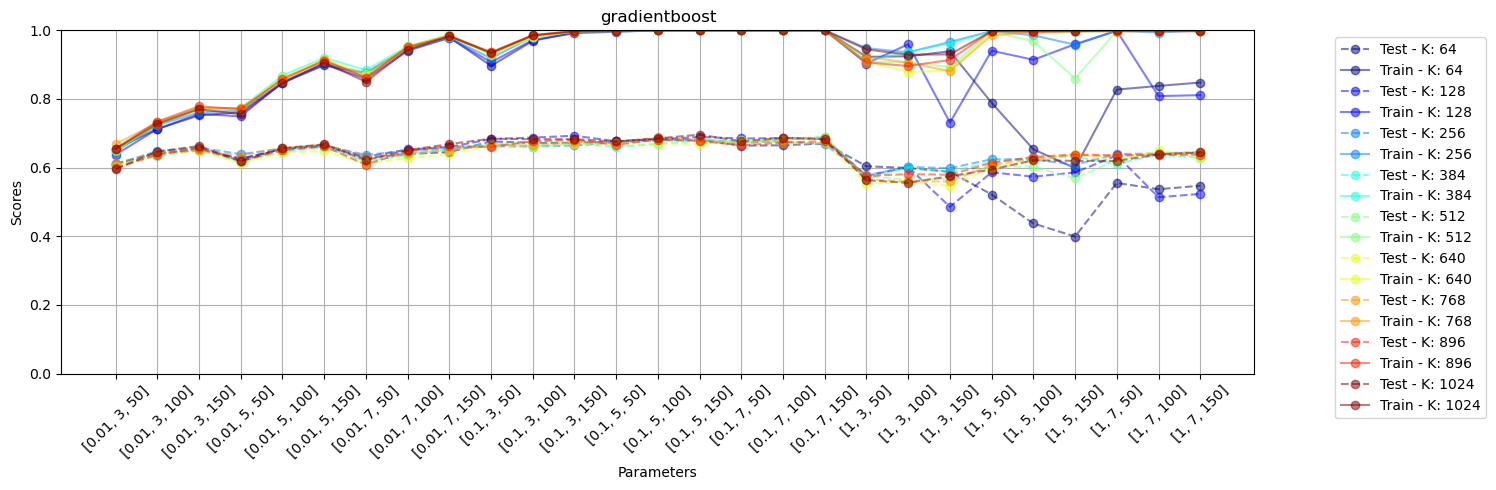

In [107]:

test_scores = {}
train_scores = {}
params = {}

for model, report in reports.items():
    test_scores[model] = []
    train_scores[model]= []
    params[model]= []
    
    for rpt in report:
        test_scores[model] .append(rpt['mean_test_score'])
        train_scores[model].append(rpt['mean_train_score'])
        params[model].append([str(list(p.values())) for p in rpt['params']])

color_map = {}
colors = plt.cm.jet(np.linspace(0, 1, len(KS)))

for idx, k in enumerate(KS):
    color_map[k] = colors[idx]

for test, train, model in zip(test_scores.items(), train_scores.items(), params.items()):
    
    if not test[1]:
        continue
    plt.figure(figsize=(15, 5))
    
    for t, tr, p, k in zip(test[1], train[1], model[1], KS):
        plt.plot(p, t, marker='o', linestyle='--', alpha=0.5, label=f'Test - K: {k}', color=color_map[k])
        plt.plot(p, tr, marker='o', alpha=0.5, label=f'Train - K: {k}', color=color_map[k])
    plt.title(f'{test[0]}')
    plt.xlabel('Parameters')
    plt.ylabel('Scores')
    plt.ylim(0, 1)  # Set y-axis limits
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

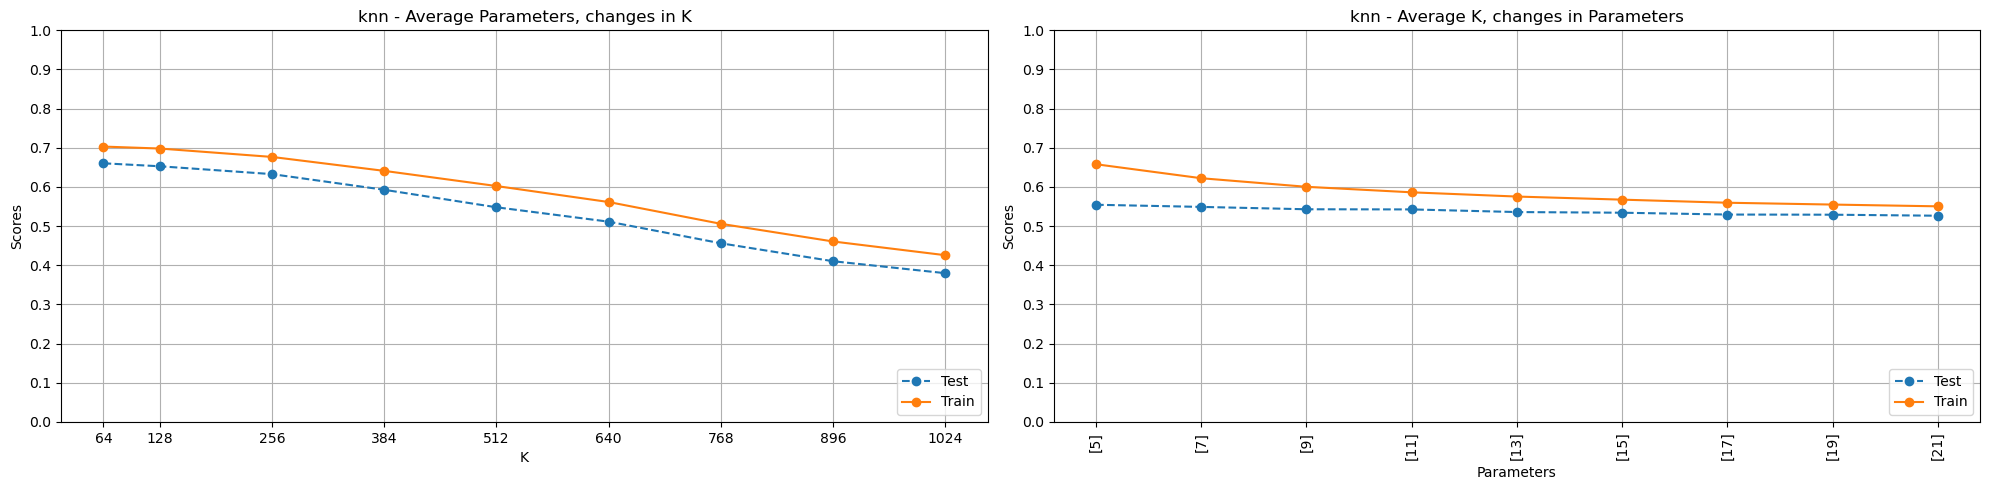

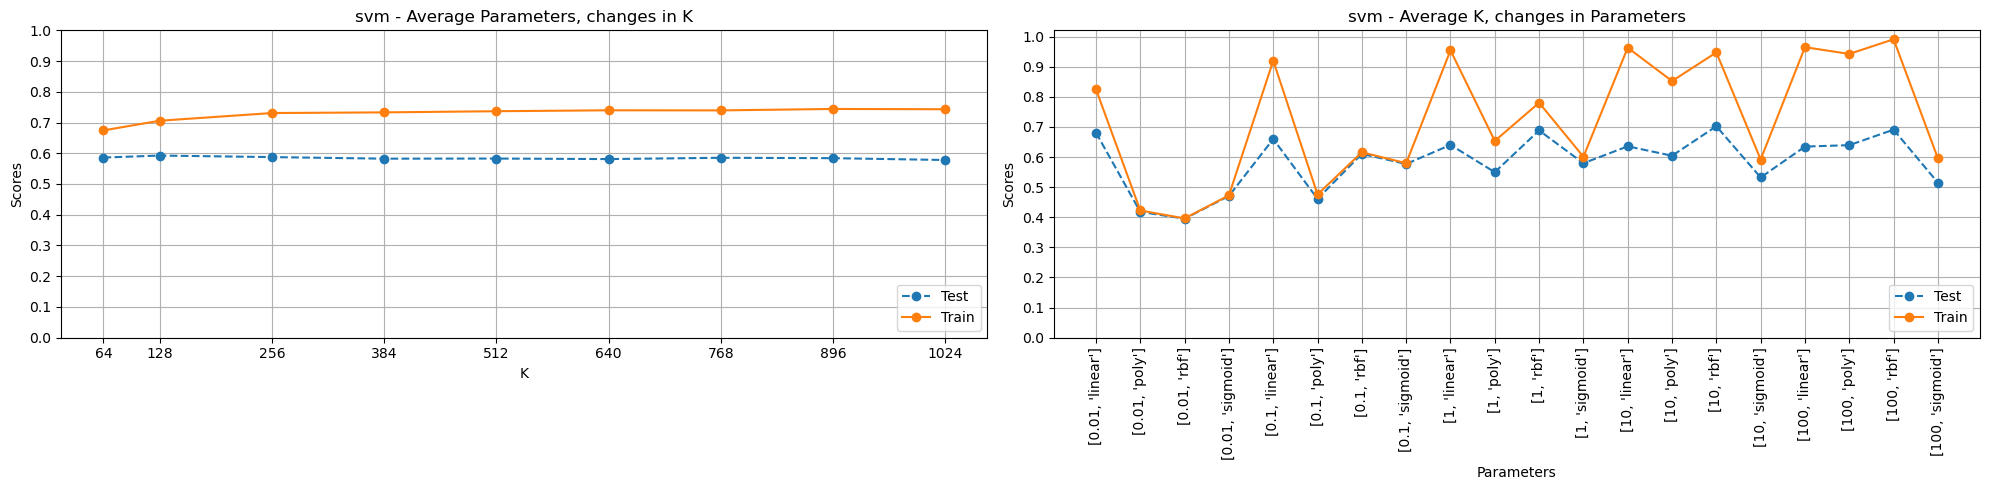

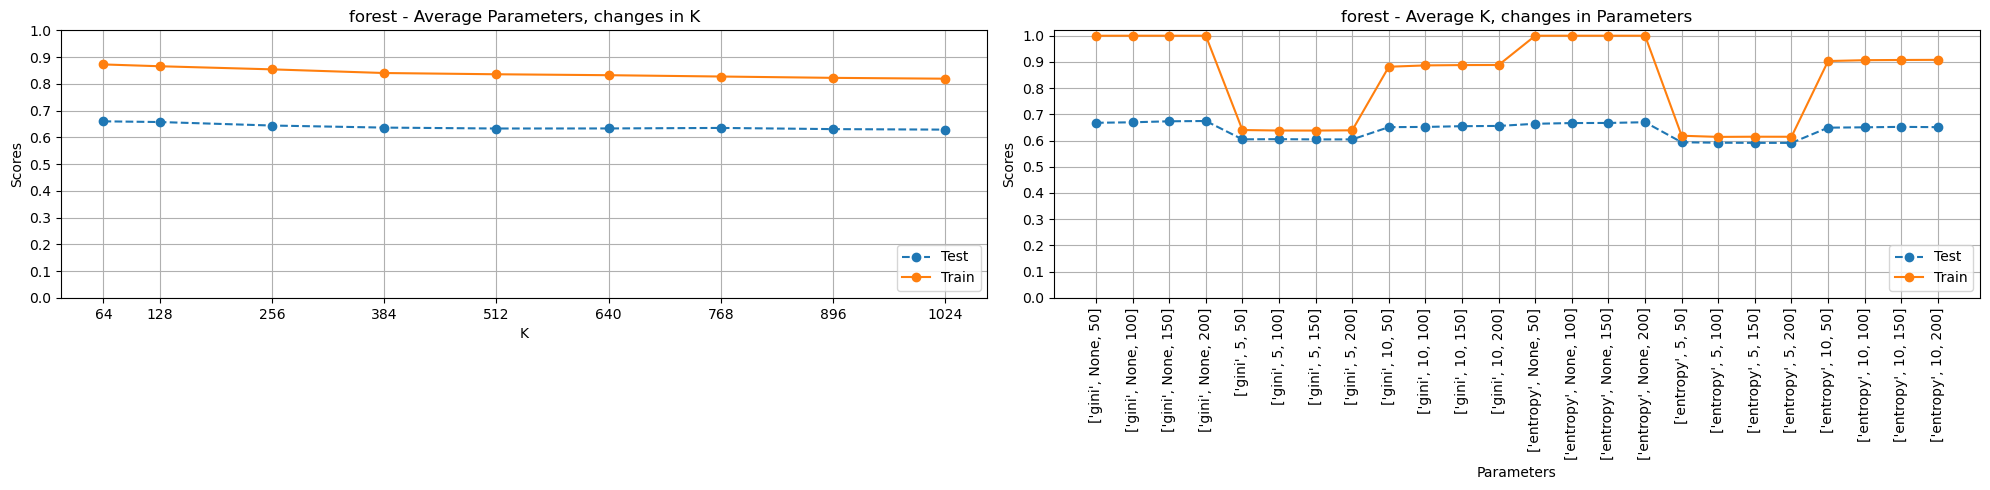

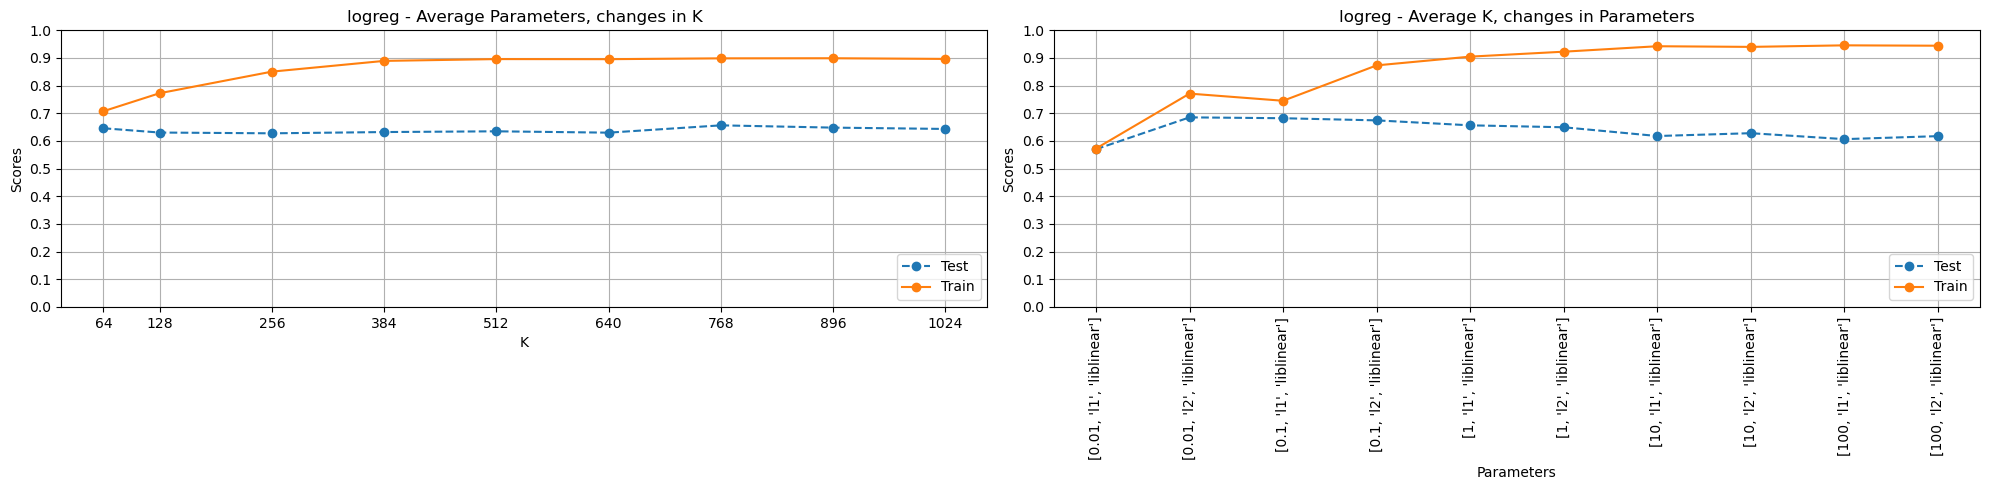

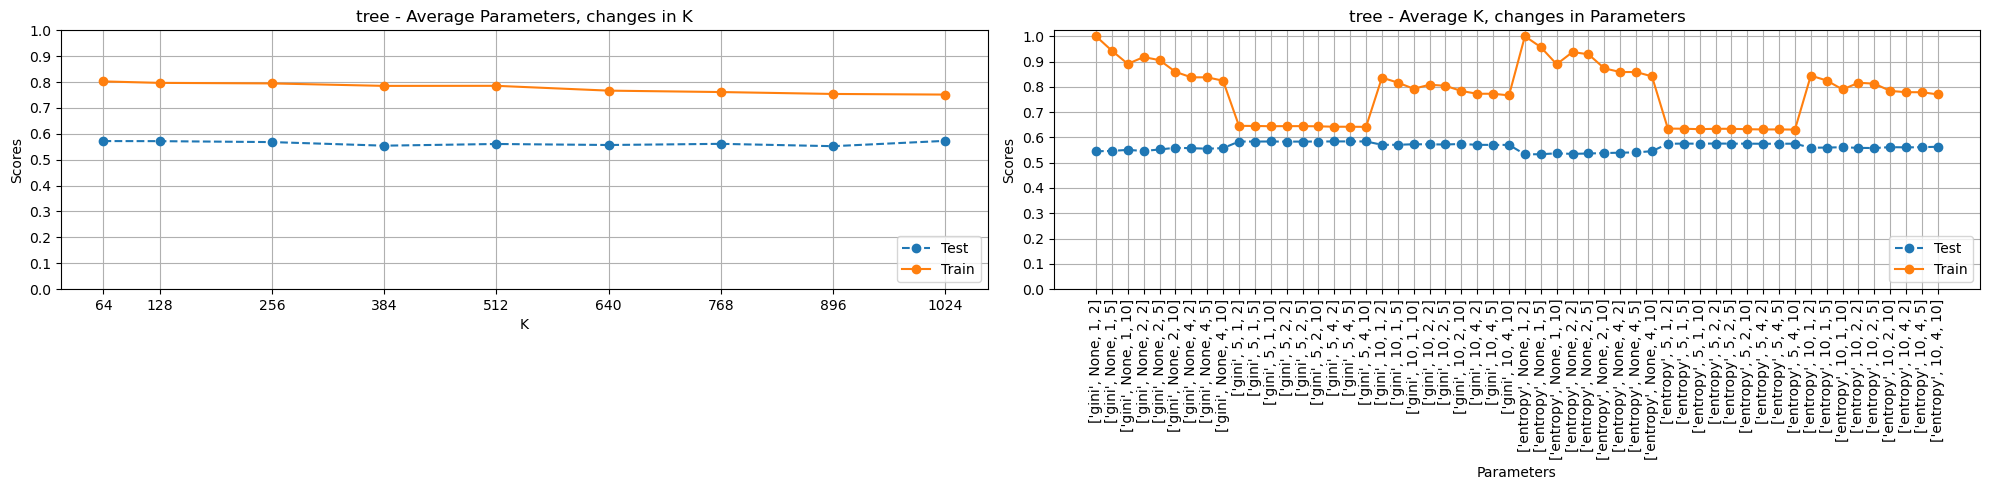

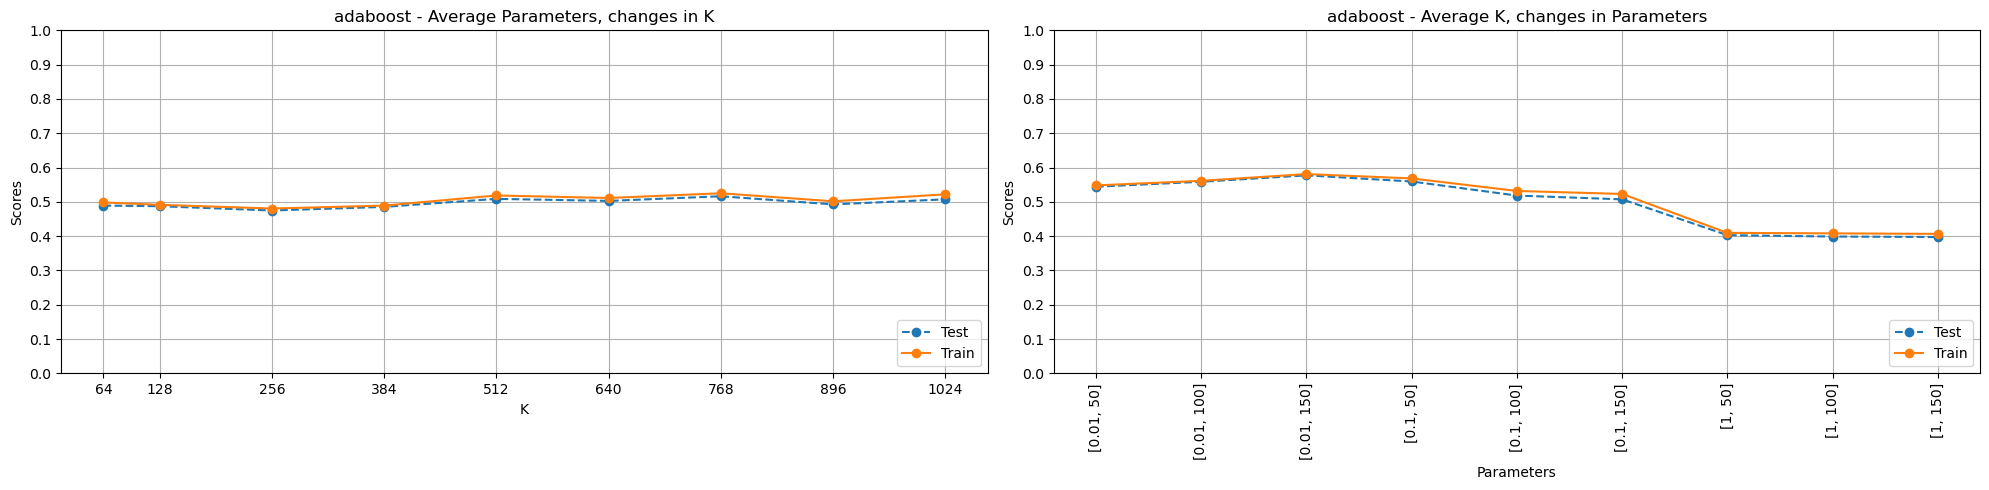

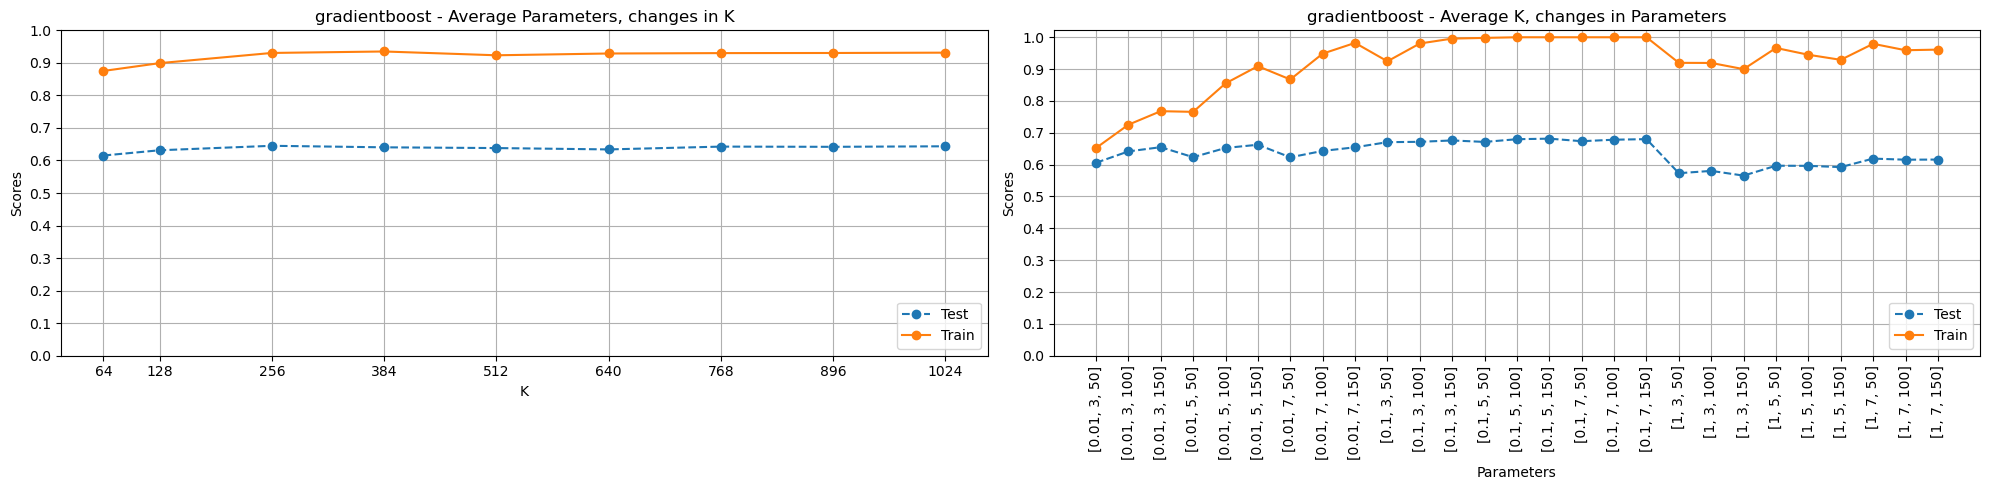

In [106]:
for test, train, model in zip(test_scores.items(), train_scores.items(), params.items()):
    
    if not test[1]:
        continue

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

 
    ax[0].plot(KS, np.mean(np.array(test[1]), axis=1), marker='o', linestyle='--', label='Test')
    ax[0].plot(KS, np.mean(np.array(train[1]), axis=1), marker='o', linestyle='-', label='Train')
    ax[0].set_title(f'{test[0]} - Average Parameters, changes in K')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Scores')
    ax[0].set_yticks(np.arange(0, 1.1, 0.1))
    ax[0].set_xticks(KS)  
    ax[0].legend(loc='lower right')
    ax[0].grid(True)
    

    ax[1].plot(model[1][0], np.mean(np.array(test[1]), axis=0), marker='o', linestyle='--', label='Test')
    ax[1].plot(model[1][0], np.mean(np.array(train[1]), axis=0), marker='o', linestyle='-', label='Train')
    ax[1].set_title(f'{test[0]} - Average K, changes in Parameters')
    ax[1].set_xlabel('Parameters')
    ax[1].set_ylabel('Scores')
    ax[1].set_yticks(np.arange(0, 1.1, 0.1))
    ax[1].set_xticks(model[1][0])
    ax[1].set_xticklabels(model[1][0], rotation=90)
    ax[1].legend(loc='lower right')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
